In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss, auc, roc_curve, roc_auc_score, accuracy_score, precision_recall_curve, confusion_matrix
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
%matplotlib inline

In [162]:
##Load data for final model
data = pd.read_csv('../ult_sign_scrape/race_master/master_database_fe4.csv')
##Load Brazos Bend 100 data for model check
cvdata = pd.read_csv('../ult_sign_scrape/race_master/BB2015.csv')

In [163]:
cvdata.head()

,Unnamed: 0,Unnamed: 0.1,age,gender,participant_id,runner_rank,status,race_id,race_name,Season,Metro_area,WL_SO,Entry_fee,PPM,Age_Rank,Gender_Rank,Total_races,Success_rate
0,0,0,26,M,524171,90.57,1,31333,BB,4,1,0,0,1.9,0.6318,0.5842,11.0,0.909091
1,1,1,39,M,58710,88.99,1,31333,BB,4,1,0,0,1.9,0.6549,0.5906,12.0,1.000000
2,2,2,30,M,1001287,78.14,1,31333,BB,4,1,0,0,1.9,1.0000,0.8036,6.0,1.000000
3,3,3,35,F,272138,87.36,1,31333,BB,4,1,0,0,1.9,0.8553,0.7416,6.0,1.000000
4,4,4,43,M,499696,76.84,1,31333,BB,4,1,0,0,1.9,0.6842,0.5989,23.0,0.956522


In [164]:
##Clean data by dropping extraneous columns
cleaned_data = data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
##Clean BB100
bb100 = cvdata.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
##Second stage of cleaning by removing na values from dataframe
cleaned_data = cleaned_data.dropna()
cleaned_data['success_metric'] = cleaned_data['Total_races'] * cleaned_data['Success_rate']

In [165]:
##Create gender dummy variables for model
gender_dummies = pd.get_dummies(cleaned_data.gender, prefix='gender')
cleaned_data = cleaned_data.join(gender_dummies)
bbgender_dummies = pd.get_dummies(bb100.gender, prefix='gender')
bb100 = bb100.join(bbgender_dummies)

In [166]:
##Consolidate all starts (code DNF with finishers) for modeling
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded
 
print 'Before Coding:'
print pd.value_counts(cleaned_data["status"])
cleaned_data["status_coded"] = coding(cleaned_data["status"], {'1':0,'2':0, '3':1})
cleaned_data['DNF_DNS_coded'] = coding(cleaned_data["status"], {'1':1,'2':0, '3':0})
##BB100 CV data:
bb100["status_coded"] = coding(bb100["status"], {'1':0,'2':0, '3':1})
bb100['DNF_DNS_coded'] = coding(bb100["status"], {'1':1,'2':0, '3':0})
print '\nAfter Coding:'
print pd.value_counts(cleaned_data["status_coded"])
print '\nAfter DNF Coding:'
print pd.value_counts(cleaned_data["DNF_DNS_coded"])
status_coded = cleaned_data.drop(['status'], axis=1)
status_DNF = cleaned_data.copy()
status_DNF = cleaned_data.drop(['status', 'status_coded'], axis=1)
bb100_coded = bb100.drop(['status'], axis=1)

Before Coding:
1    6203
2    3809
3     498
Name: status, dtype: int64

After Coding:
0    10012
1      498
Name: status_coded, dtype: int64

After DNF Coding:
1    6203
0    4307
Name: DNF_DNS_coded, dtype: int64


In [167]:
bb100_coded.tail()

,age,gender,participant_id,runner_rank,race_id,race_name,Season,Metro_area,WL_SO,Entry_fee,PPM,Age_Rank,Gender_Rank,Total_races,Success_rate,gender_F,gender_M,status_coded,DNF_DNS_coded
99,42,M,381672,66.53,31333,BB,4,1,0,0,1.9,0.0000,0.2562,1.0,1.000,0.0,1.0,1,0
100,50,M,215892,54.38,31333,BB,4,1,0,0,1.9,0.6605,0.6653,5.0,0.800,0.0,1.0,1,0
101,30,F,311007,83.48,31333,BB,4,1,0,0,1.9,0.7550,0.5721,0.0,0.000,1.0,0.0,1,0
102,38,M,749574,52.83,31333,BB,4,1,0,0,1.9,0.0000,0.0000,0.0,0.000,0.0,1.0,1,0
103,52,F,775499,47.53,31333,BB,4,1,0,0,1.9,0.9140,0.7973,8.0,0.875,1.0,0.0,1,0


In [168]:
##Set response variable for coded dataframe
y_DNS = status_coded.pop('status_coded')
##Set response variable for uncoded dataframe
y_DNF = cleaned_data.pop('status')
##Set response variable for DNF/DNS to finishers DF
y_Finish = cleaned_data.pop('DNF_DNS_coded')
##Set cross validation response for BB100
y_BB100 = bb100_coded.pop('status_coded')
##Set response variable for DNF/DNS to finishers DF for BB100
y_Finish_BB100 = bb100_coded.pop('DNF_DNS_coded')

In [169]:
##Set predictors for coded dataframe
codedX = status_coded.drop(['gender', 'participant_id', 'race_name', 'race_id'\
                 , 'gender_M', 'DNF_DNS_coded', 'success_metric'], axis=1)
##Set predictors for uncoded dataframe
uncodedX = cleaned_data.drop(['gender', 'participant_id', 'race_name', 'race_id'\
                 , 'gender_M'], axis=1)
##Set predictors for predicting DNF/DNS to finishers
finish_model = cleaned_data.drop(['gender', 'participant_id', 'race_name', 'race_id'\
                 , 'gender_M', 'status_coded', 'success_metric'], axis=1)
##Set predictors for BB100 cross validation
BB100X = bb100_coded.drop(['gender', 'participant_id', 'race_name', 'race_id'\
                 , 'gender_M'], axis=1)
##Set finisher predictors for BB100 cross validation
BB100X_Finish = bb100_coded.drop(['gender', 'participant_id', 'race_name', 'race_id'\
                 , 'gender_M'], axis=1)

In [170]:
BB100X_Finish.head()
finish_model.head()

,age,runner_rank,Season,Metro_area,WL_SO,Entry_fee,PPM,Age_Rank,Gender_Rank,Total_races,Success_rate,gender_F
0,26,88.39,3,0,1,1,2.5,0.7174,0.6806,23.0,0.956522,0.0
1,33,90.00,3,0,1,1,2.5,0.8132,0.6987,9.0,0.888889,0.0
2,43,83.63,3,0,1,1,2.5,0.8272,0.7145,17.0,0.882353,0.0
3,36,73.22,3,0,1,1,2.5,0.8995,0.8957,14.0,0.857143,0.0
4,33,87.77,3,0,1,1,2.5,0.6807,0.6522,7.0,1.000000,0.0


In [171]:
##Create test/train splits for both datasets
##coded dataframe
cX_train, cX_test, cy_train, cy_test = train_test_split(codedX, y_DNS, test_size=0.3)
##uncoded dataframe
uX_train, uX_test, uy_train, uy_test = train_test_split(uncodedX, y_DNF, test_size=0.3)
##finisher dataframe
fX_train, fX_test, fy_train, fy_test = train_test_split(finish_model, y_Finish, test_size=0.3)

In [172]:
BB100X.info(), codedX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 12 columns):
age             104 non-null int64
runner_rank     104 non-null float64
Season          104 non-null int64
Metro_area      104 non-null int64
WL_SO           104 non-null int64
Entry_fee       104 non-null int64
PPM             104 non-null float64
Age_Rank        104 non-null float64
Gender_Rank     104 non-null float64
Total_races     104 non-null float64
Success_rate    104 non-null float64
gender_F        104 non-null float64
dtypes: float64(7), int64(5)
memory usage: 9.8 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10510 entries, 0 to 10509
Data columns (total 12 columns):
age             10510 non-null int64
runner_rank     10510 non-null float64
Season          10510 non-null int64
Metro_area      10510 non-null int64
WL_SO           10510 non-null int64
Entry_fee       10510 non-null int64
PPM             10510 non-null float64
Age_Rank        10510 non-null float64


(None, None)

# Logistic Regression Modeling

In [173]:
##coded dataframe
cLR = LR(C=10)
cLR.fit(cX_train, cy_train)
cLRp = cLR.predict_proba(cX_test)
cLRpr = cLR.predict(cX_test)
print log_loss(cy_test, cLRp)
print roc_auc_score(cy_test, cLRp[:,1])
print confusion_matrix(cy_test, cLRpr)

0.186540359203
0.629224893146
[[2999    0]
 [ 154    0]]


In [174]:
##uncoded dataframe
uLR = LR(C=10)
uLR.fit(uX_train, uy_train)
uLRp = uLR.predict_proba(uX_test)
uLRa = uLR.predict(uX_test)
print log_loss(uy_test, uLRp)
print accuracy_score(uy_test, uLRa)

0.589155389153
0.680938788455


In [175]:
##Finisher dataframe
fLR = LR(C=100, penalty='l2', solver='newton-cg')
fLR.fit(fX_train, fy_train)
fLRp = fLR.predict_proba(fX_test)
fLRpr = fLR.predict(fX_test)
print log_loss(fy_test, fLRp)
print roc_auc_score(fy_test, fLRp[:,1])
print confusion_matrix(cy_test, cLRpr)

0.637551115272
0.65907091434
[[2999    0]
 [ 154    0]]


In [176]:
##Brazos Bend Cross Validation
##coded dataframe
cLR = LR(C=10)
cLR.fit(cX_train, cy_train)
cLRp = cLR.predict_proba(BB100X)
cLRpr = cLR.predict(BB100X)
print log_loss(y_BB100, cLRp)
print roc_auc_score(y_BB100, cLRp[:,1])
print confusion_matrix(y_BB100, cLRpr)

0.279240297817
0.678385416667
[[96  0]
 [ 8  0]]


In [177]:
##ROC curve
fpr, tpr, thresholds = roc_curve(cy_test, cLRp[:,1]) 
plt.plot(fpr, tpr)
plt.show()
thresholds.mean()

ValueError: Found input variables with inconsistent numbers of samples: [3153, 104]

# Random Forest

In [178]:
##coded dataframe
cRF = RFC(n_estimators=1000, criterion='gini', random_state=1, n_jobs=2)
cRF.fit(cX_train, cy_train)
cRFp = cRF.predict_proba(cX_test)
cRFpr = cRF.predict(cX_test)

print log_loss(cy_test, cRFp)
print roc_auc_score(cy_test, cRFp[:,1])
print confusion_matrix(cy_test, cRFpr)

0.206262613051
0.671220493411
[[2993    6]
 [ 154    0]]


In [181]:
# cRF = RFC(n_estimators=1000, criterion='gini', random_state=1, n_jobs=2)
# cRF.fit(cX_train, cy_train)
cRFp = cRF.predict_proba(BB100X)
cRFpr = cRF.predict(BB100X)

print log_loss(y_BB100, cRFp)
print roc_auc_score(y_BB100, cRFp[:,1])
print confusion_matrix(y_BB100, cRFpr)

0.305356471035
0.690104166667
[[96  0]
 [ 8  0]]


In [180]:
positive = []
negative = []
for each in cRFp[:,1]:
    if each > 0.002:
        positive.append(1)
        negative.append(0)
    else:
        positive.append(0)
        negative.append(1)
confusion_matrix(cy_test, negative)   

ValueError: Found input variables with inconsistent numbers of samples: [3153, 104]

In [ ]:
##uncoded dataframe
uRF = RFC(n_estimators=1000, criterion='gini', random_state=1, n_jobs=2)
uRF.fit(uX_train, uy_train)
uRFp = uRF.predict_proba(uX_test)
uRFa = uRF.predict(uX_test)
print log_loss(uy_test, uRFp)
print accuracy_score(uy_test, uRFa)
print confusion_matrix(uy_test, uRFa)

In [137]:
cX_train.head()

,age,runner_rank,Season,Metro_area,WL_SO,Entry_fee,PPM,Age_Rank,Gender_Rank,Total_races,Success_rate,gender_F
9157,26,57.74,1,1,1,1,2.50,1.0000,0.8091,1.0,1.0,0.0
1777,42,90.63,2,0,0,0,1.85,0.7352,0.6973,3.0,1.0,1.0
10093,50,64.32,3,0,1,1,2.50,0.8508,0.8094,1.0,1.0,1.0
495,55,78.77,3,0,1,1,2.50,0.6614,0.6071,2.0,0.5,1.0
10244,34,75.07,3,0,1,1,2.50,0.6954,0.6189,20.0,0.9,1.0


In [138]:
##Finisher dataframe
fRF = RFC(n_estimators=500, criterion='gini', random_state=1, n_jobs=2)
fRF.fit(fX_train, fy_train)
fRFp = fRF.predict_proba(fX_test)
fRFpr = fRF.predict(fX_test)

print log_loss(fy_test, fRFp)
print roc_auc_score(fy_test, fRFp[:,1])
print confusion_matrix(fy_test, fRFpr)

0.573519265589
0.738818496254
[[ 659  655]
 [ 302 1537]]


In [139]:
##ROC curve
fpr, tpr, thresholds = roc_curve(cy_test, cRFp[:,1]) 
labels = ['fpr', 'tpr']
RFP = plt.plot(fpr, tpr, 'r', label='Random Forest')


ValueError: Found input variables with inconsistent numbers of samples: [3153, 104]

# Gradient Boosted Classifier

In [182]:
##coded dataframe
cGBC = GBC(n_estimators=10000, max_depth=5, learning_rate=0.001)
cGBC.fit(cX_train, cy_train)
cGBCp = cGBC.predict_proba(cX_test)
cGBCpr = cGBC.predict(cX_test)
print log_loss(cy_test, cGBCp)
print roc_auc_score(cy_test, cGBCp[:,1])
print confusion_matrix(cy_test, cGBCpr)

0.199396952487
0.654423768962
[[2979   20]
 [ 153    1]]


In [183]:
cy_test.value_counts()

0    2999
1     154
Name: status_coded, dtype: int64

In [184]:
##BB100 Cross validation data
# cGBC = GBC(n_estimators=10000, max_depth=5, learning_rate=0.001)
# cGBC.fit(cX_train, cy_train)
cGBCp = cGBC.predict_proba(BB100X)
cGBCpr = cGBC.predict(BB100X)
print log_loss(y_BB100, cGBCp)
print roc_auc_score(y_BB100, cGBCp[:,1])
print confusion_matrix(y_BB100, cGBCpr)

0.384995661076
0.57421875
[[83 13]
 [ 5  3]]


In [159]:
##uncoded dataframe
uGBC = GBC(n_estimators=50, max_depth=4, learning_rate=0.1)
uGBC.fit(uX_train, uy_train)
uGBCp = uGBC.predict_proba(uX_test)
uGBCa = uGBC.predict(uX_test)
print log_loss(uy_test, uGBCp)
print accuracy_score(uy_test, uGBCa)

0.584678619002
0.685061845861


In [185]:
##Finisher dataframe
fGBC = GBC(n_estimators=1000, max_depth=8, learning_rate=0.01)
fGBC.fit(fX_train, fy_train)
fGBCp = fGBC.predict_proba(fX_test)
fGBCpr = fGBC.predict(fX_test)
print log_loss(fy_test, fGBCp)
print roc_auc_score(fy_test, fGBCp[:,1])
print confusion_matrix(fy_test, fGBCpr)
print accuracy_score(fy_test, fGBCpr)

0.641423102605
0.676536601283
[[ 569  754]
 [ 342 1488]]
0.652394544878


In [186]:
##BB100 Finishers
##Finisher dataframe
# fGBC = GBC(n_estimators=1000, max_depth=8, learning_rate=0.01)
# fGBC.fit(fX_train, fy_train)
fGBCp = fGBC.predict_proba(BB100X_Finish)
fGBCpr = fGBC.predict(BB100X_Finish)
print log_loss(y_Finish_BB100, fGBCp)
print roc_auc_score(y_Finish_BB100, fGBCp[:,1])
print confusion_matrix(y_Finish_BB100, fGBCpr)
print accuracy_score(y_Finish_BB100, fGBCpr)

0.758287497554
0.555279503106
[[53 16]
 [26  9]]
0.596153846154


In [ ]:
##ROC curve
fpr, tpr, thresholds = roc_curve(cy_test, cGBCp[:,1]) 
labels = ['fpr', 'tpr']
plt.plot(fpr, tpr, 'r')
fpr2, tpr2, thresholds = roc_curve(y_BB100, cGBCp[:,1]) 
labels = ['fpr', 'tpr']
plt.plot(fpr, tpr, 'r')
plt.plot(fpr2, tpr2, 'b')
plt.show()

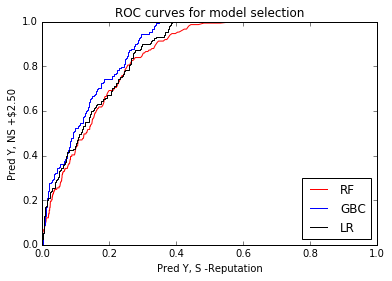

In [584]:
fpr, tpr, thresholds = roc_curve(cy_test, cRFp[:,1]) 
labels = ['fpr', 'tpr']
RFP = plt.plot(fpr, tpr, 'r', label='Random Forest')
fpr, tpr, thresholds = roc_curve(cy_test, cGBCp[:,1]) 
GBCP = plt.plot(fpr, tpr, 'b', label='Gradient Boosted Classifier')
fpr, tpr, thresholds = roc_curve(cy_test, cLRp[:,1]) 
LRP = plt.plot(fpr, tpr, 'k', label='Logistic Regression')
plt.ylabel('Pred Y, NS +$2.50')
plt.xlabel('Pred Y, S -Reputation')
plt.title('ROC curves for model selection')
plt.legend(['RF', 'GBC', 'LR'], loc=4)
plt.show()

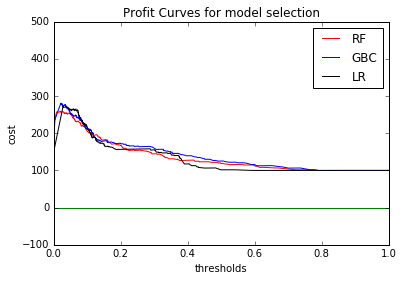

In [586]:
TPC = 250.
FPC = -100.
FNC = 0.
TNC = 100.
fpr, tpr, thresholds = roc_curve(cy_test, cRFp[:,1]) 
labels = ['fpr', 'tpr']
cost = (tpr * TPC) + ((1 - fpr) * TNC) + (fpr * FPC) + ((1 - tpr) * FNC)
RFP = plt.plot(thresholds, cost, 'r', label='Random Forest')
fpr, tpr, thresholds = roc_curve(cy_test, cGBCp[:,1])
cost = (tpr * TPC) + ((1 - fpr) * TNC) + (fpr * FPC) + ((1 - tpr) * FNC)
GBcost = plt.plot(thresholds, cost, 'b', label='Gradient Boosted Classifier')
fpr, tpr, thresholds = roc_curve(cy_test, cLRp[:,1]) 
cost = (tpr * TPC) + ((1 - fpr) * TNC) + (fpr * FPC) + ((1 - tpr) * FNC)
LRP = plt.plot(thresholds, cost, 'k', label='Logistic Regression')
plt.axhline(0, color='g')
plt.ylabel('cost')
plt.xlabel('thresholds')
plt.title('Profit Curves for model selection')
plt.axis([0, 1, -100, 500])
plt.legend(['RF', 'GBC', 'LR'], loc=1)
plt.show()

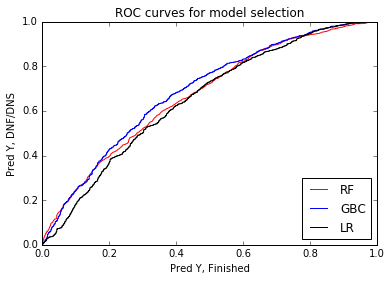

In [537]:
fpr, tpr, thresholds = roc_curve(fy_test, fRFp[:,1]) 
labels = ['fpr', 'tpr']
RFP = plt.plot(fpr, tpr, 'r', label='Random Forest')
fpr, tpr, thresholds = roc_curve(fy_test, fGBCp[:,1]) 
GBCP = plt.plot(fpr, tpr, 'b', label='Gradient Boosted Classifier')
fpr, tpr, thresholds = roc_curve(fy_test, fLRp[:,1]) 
LRP = plt.plot(fpr, tpr, 'k', label='Logistic Regression')
plt.ylabel('Pred Y, DNF/DNS')
plt.xlabel('Pred Y, Finished')
plt.title('ROC curves for model selection')
plt.legend(['RF', 'GBC', 'LR'], loc=4)
plt.show()

In [269]:
# TPC = 175.
# FPC = -250.
# FNC = 175.
# TNC = -250.
# fpr, tpr, thresholds = roc_curve(fy_test, fRFp[:,1]) 
# labels = ['fpr', 'tpr']
# cost = (tpr * TPC) + ((1 - fpr) * TNC) + (fpr * FPC) + ((1 - tpr) * FNC)
# RFP = plt.plot(thresholds, cost, 'r', label='Random Forest')
# fpr, tpr, thresholds = roc_curve(fy_test, fGBCp[:,1])
# cost = (tpr * TPC) + ((1 - fpr) * TNC) + (fpr * FPC) + ((1 - tpr) * FNC)
# GBcost = plt.plot(thresholds, cost, 'b', label='Gradient Boosted Classifier')
# fpr, tpr, thresholds = roc_curve(fy_test, fLRp[:,1]) 
# cost = (tpr * TPC) + ((1 - fpr) * TNC) + (fpr * FPC) + ((1 - tpr) * FNC)
# LRP = plt.plot(thresholds, cost, 'k', label='Logistic Regression')
# plt.axhline(0, color='g')
# plt.ylabel('cost')
# plt.xlabel('thresholds')
# plt.title('Profit Curves for model selection')
# plt.axis([0, 1, -500, 500])
# plt.legend(['RF', 'GBC', 'LR'], loc=1)
# plt.show()